In [1]:
import os
import shutil
from pathlib import Path
import random
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm
import random
from collections import Counter
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
sns.set_palette('husl')


print("librabries imported successfully")


librabries imported successfully


In [ ]:
raw_base_dir = Path('../data/raw/cell_images')
raw_parasited_dir = raw_base_dir / 'Parasitized'
raw_uninfected_dir = raw_base_dir / 'Uninfected'
healthy_and_infected = Path("../data/processed")
train_dir = healthy_and_infected /"train"
val_dir = healthy_and_infected /"val"
test_dir = healthy_and_infected / "test"
 #Verify paths exist
print("Checking if directories exist...")
print(f"Base directory exists: {raw_base_dir.exists()}")
print(f"Parasitized directory exists: {raw_parasited_dir.exists()}")
print(f"Uninfected directory exists: {raw_uninfected_dir.exists()}")
print(f"processed directory exists: {healthy_and_infected.exists()}")
print(f"validation directory exists: {val_dir.exists()}")
print(f"training directory exists: {train_dir.exists()}")
print(f"test directory exists: {test_dir.exists()}")

# The ratios 
train_ratio = 0.7
test_ratio = 0.15
val_ratio = 0.15

seed = 42
torch.manual_seed(seed)

batch_size = 32



Checking if directories exist...
Base directory exists: True
Parasitized directory exists: True
Uninfected directory exists: True
processed directory exists: True
validation directory exists: True
training directory exists: True
test directory exists: True


*Now we need to craete infected and uninfected folders in each directory of the processed folder*

it needs to look like this """
Create the organized directory structure for split data

Structure:
processed/
├── train/
│   ├── Parasitized/
│   └── Uninfected/
├── val/
│   ├── Parasitized/
│   └── Uninfected/
└── test/
    ├── Parasitized/
    └── Uninfected/
"""

**The split function**

In [3]:
# function to copy files
""" need to run this only once"""
"""def copy_files(file_list,dest_dir):
    dest_dir.mkdir(parents=True,exist_ok = True)
    for file_path in file_list:
        shutil.copy(file_path,dest_dir/ file_path.name)
# Iterate over classes
all_images = list(raw_parasited_dir.glob("*.png"))#all image files
random.shuffle(all_images)

total = len(all_images)
train_end = int(train_ratio*total)
val_end = train_end + int(val_ratio*total)

train_files = all_images[:train_end]
val_files = all_images[train_end:val_end]
test_files = all_images[val_end:]

#copy to processed files
copy_files(train_files,train_dir /"infected")
copy_files(val_files,val_dir /"infected")
copy_files(test_files,test_dir /"infected")

print(f"{"infected"} split: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")

all_images = list(raw_uninfected_dir.glob("*.*")) #all image files
random.shuffle(all_images)

total = len(all_images)
train_end = int(train_ratio*total)
val_end = train_end + int(val_ratio*total)

train_files = all_images[:train_end]
val_files = all_images[train_end:val_end]
test_files = all_images[val_end:]

#copy to processed files
copy_files(train_files,train_dir /"uninfected")
copy_files(val_files,val_dir /"uninfected")
copy_files(test_files,test_dir /"uninfected")

print(f"{"uninfected"} split: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")"""


    

'def copy_files(file_list,dest_dir):\n    dest_dir.mkdir(parents=True,exist_ok = True)\n    for file_path in file_list:\n        shutil.copy(file_path,dest_dir/ file_path.name)\n# Iterate over classes\nall_images = list(raw_parasited_dir.glob("*.png"))#all image files\nrandom.shuffle(all_images)\n\ntotal = len(all_images)\ntrain_end = int(train_ratio*total)\nval_end = train_end + int(val_ratio*total)\n\ntrain_files = all_images[:train_end]\nval_files = all_images[train_end:val_end]\ntest_files = all_images[val_end:]\n\n#copy to processed files\ncopy_files(train_files,train_dir /"infected")\ncopy_files(val_files,val_dir /"infected")\ncopy_files(test_files,test_dir /"infected")\n\nprint(f"{"infected"} split: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")\n\nall_images = list(raw_uninfected_dir.glob("*.*")) #all image files\nrandom.shuffle(all_images)\n\ntotal = len(all_images)\ntrain_end = int(train_ratio*total)\nval_end = train_end + int(val_ratio*total)\n\ntra

# we need to run the above cell only once 
*infected split: 9645 train, 2066 val, 2068 test*
*uninfected split: 9646 train, 2067 val, 2067 test*

In [4]:
train_healthy = Path('../data/processed/train/uninfected')
train_infected = Path('../data/processed/train/infected')
test_healthy = Path('../data/processed/test/uninfected')
test_infected = Path('../data/processed/test/infected')
val_healthy = Path('../data/processed/val/uninfected')
val_infected = Path('../data/processed/val/infected')


print("{} Infected training images:".format(len(os.listdir(train_infected))))
print("{} Uninfected training images:".format(len(os.listdir(train_healthy))))
print(" {} Infected valid images:".format(len(os.listdir(val_infected))))
print(" {} Uninfected valid images:".format(len(os.listdir(val_healthy))))
print(" {} Infected testing images:".format(len(os.listdir(test_infected))))
print(" {} Uninfected testing images:".format(len(os.listdir(test_healthy))))


9645 Infected training images:
9646 Uninfected training images:
 2066 Infected valid images:
 2067 Uninfected valid images:
 2068 Infected testing images:
 2067 Uninfected testing images:


*now we proceed with intializing the transformers*

In [9]:
train_transform = transforms.Compose([
    transforms.Resize((160,160)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(
        brightness = 0.2,
        contrast = 0.2,
        saturation = 0.2,
        hue = 0.1
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
])
eval_transforms = transforms.Compose([
    transforms.Resize((160,160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

**Now we load all the datsets we need with imagefollder**

In [10]:
full_train_dataset = ImageFolder(root =train_dir,transform = train_transform )
full_test_dataset = ImageFolder(root = test_dir,transform = eval_transforms)
full_val_dataset = ImageFolder(root = val_dir,transform = eval_transforms)
print(f"Train dataset: {len(full_train_dataset)} images")
print(f"Val dataset: {len(full_val_dataset)} images")
print(f"Test dataset: {len(full_test_dataset)} images")

Train dataset: 19290 images
Val dataset: 4133 images
Test dataset: 4135 images


*now the dataloaders*

In [12]:
train_loader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2,drop_last=False)
val_loader = DataLoader(full_val_dataset, batch_size=batch_size, shuffle=False, num_workers=2,drop_last=False)
test_loader = DataLoader(full_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2,drop_last = False)

# Sanity check
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

torch.Size([64, 3, 160, 160]) torch.Size([64])


**now let's see hopw the augmentation affected our data**


VISUALIZING DATA AUGMENTATION



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5418272..1.7589979].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7502832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.6244541].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4390787..0.9049674].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.2048976].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5418272..0.9480264].


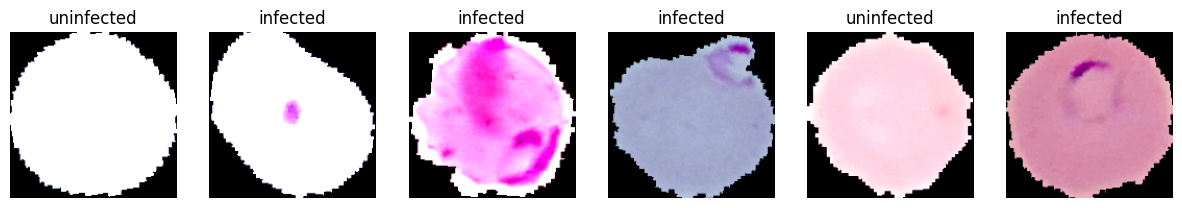

✅ Visualization saved to: ..\results\data_augmentation_visualization.png


In [13]:
result_dir = Path('../results')
def show_images(loader, num_images=6):
    imgs, lbls = next(iter(loader))
    imgs = imgs[:num_images]
    lbls = lbls[:num_images]
    
    fig, axs = plt.subplots(1, num_images, figsize=(15,3))
    for i in range(num_images):
        img = imgs[i].permute(1,2,0).numpy() * 0.5 + 0.5  # unnormalize
        axs[i].imshow(img)
        axs[i].set_title(full_train_dataset.classes[lbls[i]])
        axs[i].axis('off')
    save_path = result_dir/ 'data_augmentation_visualization.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Visualization saved to: {save_path}")

print("\n" + "="*70)
print("VISUALIZING DATA AUGMENTATION")
print("="*70 + "\n")

show_images(train_loader)
